In [1]:
import urllib
import torch
from skimage import io
from torchvision import models
import numpy as np
from torch.utils.data import Dataset
import albumentations as albu
from albumentations.pytorch import ToTensor
from torch import nn

import catalyst
import catalyst.dl as dl
from catalyst.utils import imread
import torch.nn.functional as F
from glob import glob
import pandas as pd
import scipy.io as sio


In [86]:
from catalyst import utils
SEED = 42
utils.set_global_seed(SEED)
utils.prepare_cudnn(deterministic=True)

In [161]:
all_im = list(glob("cats_images/*"))


In [162]:
valid_transformation = albu.Compose([albu.Normalize(), ToTensor()])
im1_ = imread("2222955.jpg")
im2_ = imread(all_im[1])

im1 = valid_transformation(image=im1_)["image"].unsqueeze(0)
im2 = valid_transformation(image=im2_)["image"].unsqueeze(0)


In [2]:
# def pre_transform(image_size: int = 224):
#     return albu.Resize(224, 224, p=1)


# def augmentations(image_size: int = 224):
#     channel_augs = [
#         albu.HueSaturationValue(p=0.5),
#         albu.ChannelShuffle(p=0.5),
#     ]

#     result = [
#         albu.OneOf(
#             [albu.IAAAdditiveGaussianNoise(), albu.GaussNoise(),], p=0.5
#         ),
#         albu.OneOf(
#             [
#                 albu.MotionBlur(blur_limit=3, p=0.7),
#                 albu.MedianBlur(blur_limit=3, p=1.0),
#                 albu.Blur(blur_limit=3, p=0.7),
#             ],
#             p=0.5,
#         ),
#         albu.OneOf(channel_augs),
#         albu.OneOf(
#             [albu.CLAHE(clip_limit=2), albu.IAASharpen(), albu.IAAEmboss(),],
#             p=0.5,
#         ),
#         albu.RandomBrightnessContrast(
#             brightness_limit=0.5, contrast_limit=0.5, p=0.5
#         ),
#         albu.RandomGamma(p=0.5),
#         albu.OneOf([albu.MedianBlur(p=0.5), albu.MotionBlur(p=0.5)]),
#         albu.RandomGamma(gamma_limit=(85, 115), p=0.5),
#     ]
#     return albu.Compose(result)


# def post_transform():
#     return albu.Compose([albu.Normalize(), ToTensor()])

# train_transformation = albu.Compose(
#     [pre_transform(), augmentations(), post_transform()]
# )

# valid_transformation = albu.Compose(
#     [pre_transform(), post_transform()]
# )

In [57]:
def pre_transforms(image_size=512):
    return [albu.Resize(image_size, image_size, p=1)]


def hard_transforms():
    result = [
      albu.RandomRotate90(),
      albu.Cutout(),
      albu.RandomBrightnessContrast(
          brightness_limit=0.2, contrast_limit=0.2, p=0.3
      ),
      albu.GridDistortion(p=0.3),
      albu.HueSaturationValue(p=0.3)
    ]

    return result
  

def resize_transforms(image_size=512):
    BORDER_CONSTANT = 0
    pre_size = int(image_size * 1.5)

    random_crop = albu.Compose([
      albu.SmallestMaxSize(pre_size, p=1),
      albu.RandomCrop(
          image_size, image_size, p=1
      )

    ])

    rescale = albu.Compose([albu.Resize(image_size, image_size, p=1)])

    random_crop_big = albu.Compose([
      albu.LongestMaxSize(pre_size, p=1),
      albu.RandomCrop(
          image_size, image_size, p=1
      )

    ])

    # Converts the image to a square of size image_size x image_size
    result = [
      albu.OneOf([
          random_crop,
          rescale,
          random_crop_big
      ], p=1)
    ]

    return result
  
def post_transforms():
    # we use ImageNet image normalization
    # and convert it to torch.Tensor
    return [albu.Normalize(), ToTensor()]
  
def compose(transforms_to_compose):
    # combine all augmentations into single pipeline
    result = albu.Compose([
      item for sublist in transforms_to_compose for item in sublist
    ])
    return result


train_transforms = compose([
    pre_transforms(),
    resize_transforms(), 
    hard_transforms(), 
    post_transforms()
])
valid_transforms = compose([pre_transforms(), post_transforms()])

show_transforms = compose([resize_transforms(), hard_transforms()])

my_transforms = compose([
#     resize_transforms(), 
    hard_transforms(), 
    post_transforms()
])

In [4]:
classes_map ={'head': 1,
              'lear': 2,
              'rear': 3,
              'leye': 4,
              'reye': 5,
              'nose': 6,
              'torso': 7,
              'neck': 8,
              'lfleg': 9,
              'lfpa': 10,
              'rfleg': 11,
              'rfpa': 12,
              'lbleg': 13,
              'lbpa': 14,
              'rbleg': 15,
              'rbpa': 16,
              'tail': 17,
              'background': 0}

class SegmentationDataset(Dataset):
    def __init__(self, path_to_csv="train.csv", masks=True, transforms=None) -> None:
        self.df = pd.read_csv(path_to_csv)        
        self.transforms = transforms
        self.masks = masks

    def __len__(self) -> int:
        return len(self.df)

    def __getitem__(self, idx: int) -> dict:
        image_path = self.df['image'][idx]
        mask_path = self.df['mask'][idx]
        
        image = imread(image_path)
        
        if mask_path is np.nan:
            mask = self._create_empty_mask(image.shape[:2])
        else:
            mat_file = sio.loadmat(self.df['mask'][idx])
            mask = self._create_mask(mat_file)        
        
        result = {"image": image}
        
        if self.masks is not None:
            result["mask"] = mask
        
        if self.transforms is not None:
            result = self.transforms(**result)            
            result['mask'] = torch.squeeze(result['mask']).permute(2, 0, 1)
        
        return result
    
    def _create_mask(self, mat_file):
        list_classes = mat_file['anno'][0][0][1][0]

        w, h = list_classes[0][2].shape    
        out_array = np.zeros([18, w, h], dtype='int')
        out_array[0] = np.ones([w, h], dtype="int")

        insert_classes = [0]
        for k, i in enumerate(list_classes):
            if i[0][0] == 'cat':         
                for i in list_classes[k][3][0]:                
                    index = classes_map[i[0][0]]
                    out_array[index] += i[1].copy()
                    if index not in insert_classes:
                        insert_classes.append(index)


        out_array = out_array.clip(0, 1)    
        insert_classes.sort()

        for i in range(len(insert_classes)-1):
            for j in range(i+1, len(insert_classes)):            
                out_array[insert_classes[i]] -= out_array[insert_classes[j]]

        return np.transpose(out_array.clip(0, 1).astype(np.uint8),[1, 2, 0]) * 255
    
    def _create_empty_mask(self, size, n_class=18):
        h, w = size
        mask = np.zeros([h,w, n_class], dtype=np.uint8)
        mask[:,:,0] = np.ones([h, w], dtype=np.uint8) * 255
        return mask        

In [80]:
from torch.utils.data import DataLoader, random_split


batch_size = 8
num_workers = 8

mask = True


train_loader = DataLoader(
    SegmentationDataset(
        'train.csv', mask, train_transforms
    ),
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    drop_last=True,
)

valid_loader = DataLoader(
    SegmentationDataset(
        "val.csv", mask, valid_transforms
    ),
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
)

loaders = {"train": train_loader, "valid": valid_loader}

In [117]:
from random import randint

s = SegmentationDataset("train.csv", True, train_transforms)
rnd = randint(0, len(s)-1)
ss = s[rnd]
# t = train_transforms(image=i,mask=m)
i = ss['image']
m = ss['mask']


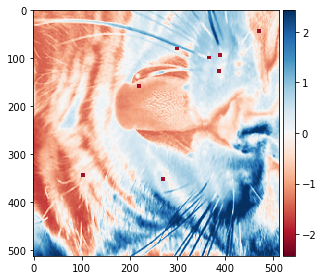

In [118]:
io.imshow(i[1,:,:].numpy());

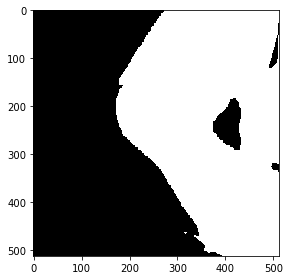

In [119]:
io.imshow(m[1,:,:].numpy());

In [75]:
def initialize_weights(*models):
    for model in models:
        for m in model.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight.data, nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1.)
                m.bias.data.fill_(1e-4)
            elif isinstance(m, nn.Linear):
                m.weight.data.normal_(0.0, 0.0001)
                m.bias.data.zero_()


class ResNet(nn.Module):
    def __init__(self, in_channels=3, output_stride=16, backbone='resnet50', pretrained=True):
        super(ResNet, self).__init__()
        model = getattr(models, backbone)(pretrained)
 
        self.layer0 = nn.Sequential(*list(model.children())[:4])
        
        self.layer1 = model.layer1
        self.layer2 = model.layer2
        self.layer3 = model.layer3
        self.layer4 = model.layer4

        if output_stride == 16: s3, s4, d3, d4 = (2, 1, 1, 2)
        elif output_stride == 8: s3, s4, d3, d4 = (1, 1, 2, 4)
        
        if output_stride == 8: 
            for n, m in self.layer3.named_modules():                
                if 'conv2' in n:
                    m.dilation, m.padding, m.stride = (d3,d3), (d3,d3), (s3,s3)
                elif 'downsample.0' in n:
                    m.stride = (s3, s3)

        for n, m in self.layer4.named_modules():
            if 'conv2' in n:
                m.dilation, m.padding, m.stride = (d4,d4), (d4,d4), (s4,s4)
            elif 'downsample.0' in n:
                m.stride = (s4, s4)

    def forward(self, x):
        x = self.layer0(x)
        x = self.layer1(x)
        low_level_features = x
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        return x, low_level_features
    
    

    
def assp_branch(in_channels, out_channles, kernel_size, dilation):
    padding = 0 if kernel_size == 1 else dilation
    return nn.Sequential(
            nn.Conv2d(in_channels, out_channles, kernel_size, padding=padding, dilation=dilation, bias=False),
            nn.BatchNorm2d(out_channles),
            nn.ReLU(inplace=True))

class ASSP(nn.Module):
    def __init__(self, in_channels, output_stride):
        super(ASSP, self).__init__()

        assert output_stride in [8, 16], 'Only output strides of 8 or 16 are suported'
        if output_stride == 16: dilations = [1, 6, 12, 18]
        elif output_stride == 8: dilations = [1, 12, 24, 36]
        
        self.aspp1 = assp_branch(in_channels, 256, 1, dilation=dilations[0])
        self.aspp2 = assp_branch(in_channels, 256, 3, dilation=dilations[1])
        self.aspp3 = assp_branch(in_channels, 256, 3, dilation=dilations[2])
        self.aspp4 = assp_branch(in_channels, 256, 3, dilation=dilations[3])

        self.avg_pool = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Conv2d(in_channels, 256, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True))
        
        self.conv1 = nn.Conv2d(256*5, 256, 1, bias=False)
        self.bn1 = nn.BatchNorm2d(256)
        self.relu = nn.ReLU(inplace=True)
        self.dropout = nn.Dropout(0.5)

        initialize_weights(self)

    def forward(self, x):
        x1 = self.aspp1(x)
        x2 = self.aspp2(x)
        x3 = self.aspp3(x)
        x4 = self.aspp4(x)        
        x5 = F.interpolate(self.avg_pool(x), size=(x.size(2), x.size(3)), mode='bilinear', align_corners=True)

        x = self.conv1(torch.cat((x1, x2, x3, x4, x5), dim=1))
        x = self.bn1(x)
        x = self.dropout(self.relu(x))

        return x
        
class Decoder(nn.Module):
    def __init__(self, low_level_channels, num_classes):
        super(Decoder, self).__init__()
        self.conv1 = nn.Conv2d(low_level_channels, 48, 1, bias=False)
        self.bn1 = nn.BatchNorm2d(48)
        self.relu = nn.ReLU(inplace=True)

       
        self.output = nn.Sequential(
            nn.Conv2d(48+256, 256, 3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, 3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.1),
            nn.Conv2d(256, num_classes, 1, stride=1),
        )
        initialize_weights(self)

    def forward(self, x, low_level_features):
        low_level_features = self.conv1(low_level_features)
        low_level_features = self.relu(self.bn1(low_level_features))
        H, W = low_level_features.size(2), low_level_features.size(3)

        x = F.interpolate(x, size=(H, W), mode='bilinear', align_corners=True)
        x = self.output(torch.cat((low_level_features, x), dim=1))
        return x

In [76]:
class DeepLab(nn.Module):
    def __init__(self, num_classes, in_channels=3, pretrained=True, 
                output_stride=16, freeze_bn=False, freeze_backbone=False, **_):
                
        super(DeepLab, self).__init__()        
        self.backbone = ResNet(in_channels=in_channels, output_stride=output_stride, pretrained=pretrained)
        low_level_channels = 256
        self.ASSP = ASSP(in_channels=2048, output_stride=output_stride)
        self.decoder = Decoder(low_level_channels, num_classes)

        if freeze_bn: self.freeze_bn()
        if freeze_backbone: 
            set_trainable([self.backbone], False)

    def forward(self, x):
        H, W = x.size(2), x.size(3)
        x, low_level_features = self.backbone(x)
        x = self.ASSP(x)
        x = self.decoder(x, low_level_features)
        x = F.interpolate(x, size=(H, W), mode='bilinear', align_corners=True)
        return x



    def get_backbone_params(self):
        return self.backbone.parameters()

    def get_decoder_params(self):
        return chain(self.ASSP.parameters(), self.decoder.parameters())

    def freeze_bn(self):
        for module in self.modules():
            if isinstance(module, nn.BatchNorm2d): module.eval()
    
    def summary(self):
        model_parameters = filter(lambda p: p.requires_grad, self.parameters())
        nbr_params = sum([np.prod(p.size()) for p in model_parameters])
        self.logger.info(f'Nbr of trainable parameters: {nbr_params}')

       

In [82]:
from catalyst.contrib.nn.optimizers.radam import RAdam
from catalyst.contrib.nn.criterion import DiceLoss, IoULoss


model = DeepLab(18)
criterion = {
    "dice": DiceLoss(),
    "iou": IoULoss(),
    "bce": nn.BCEWithLogitsLoss()
}
optimizer = RAdam(model.parameters(), lr=1e-3)
callbacks = [
    dl.CriterionCallback(
        input_key="mask", prefix="loss_dice", criterion_key="dice"
    ),
    dl.CriterionCallback(
        input_key="mask", prefix="loss_iou", criterion_key="iou"
    ),
    dl.CriterionCallback(
        input_key="mask", prefix="loss_bce", criterion_key="bce"
    ),
    dl.MetricAggregationCallback(
        prefix="loss",
        mode="weighted_sum",
        metrics={"loss_dice": 1.0, "loss_iou": 1.0, "loss_bce": 0.8},
    ),
    dl.DiceCallback(input_key="mask"),
    dl.IouCallback(input_key="mask"),
]

In [84]:
from datetime import datetime
from pathlib import Path


runner = dl.SupervisedRunner(input_key="image", input_target_key="mask")


runner.train(
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    loaders=loaders,
    callbacks=callbacks,
    logdir=Path("logs") / datetime.now().strftime("%Y%m%d-%H%M%S"),
    num_epochs=60,
    main_metric="iou",
    minimize_metric=False,
    verbose=True,
)

1/60 * Epoch (train): 100% 100/100 [02:11<00:00,  1.32s/it, dice=0.389, iou=0.241, loss=1.522, loss_bce=0.190, loss_dice=0.611, loss_iou=0.759]
1/60 * Epoch (valid): 100% 26/26 [00:14<00:00,  1.75it/s, dice=0.213, iou=0.119, loss=1.907, loss_bce=0.300, loss_dice=0.787, loss_iou=0.881]
[2020-12-01 12:01:10,255] 
1/60 * Epoch 1 (_base): lr=0.0010 | momentum=0.9000
1/60 * Epoch 1 (train): dice=0.2465 | iou=0.1426 | loss=1.9363 | loss_bce=0.4067 | loss_dice=0.7535 | loss_iou=0.8574
1/60 * Epoch 1 (valid): dice=0.3959 | iou=0.2474 | loss=1.5184 | loss_bce=0.2021 | loss_dice=0.6041 | loss_iou=0.7526
2/60 * Epoch (train): 100% 100/100 [02:10<00:00,  1.31s/it, dice=0.480, iou=0.316, loss=1.378, loss_bce=0.218, loss_dice=0.520, loss_iou=0.684]
2/60 * Epoch (valid): 100% 26/26 [00:12<00:00,  2.03it/s, dice=0.462, iou=0.300, loss=1.361, loss_bce=0.154, loss_dice=0.538, loss_iou=0.700]
[2020-12-01 12:03:35,884] 
2/60 * Epoch 2 (_base): lr=0.0010 | momentum=0.9000
2/60 * Epoch 2 (train): dice=0.533

15/60 * Epoch (train): 100% 100/100 [02:10<00:00,  1.31s/it, dice=0.752, iou=0.602, loss=0.742, loss_bce=0.120, loss_dice=0.248, loss_iou=0.398]
15/60 * Epoch (valid): 100% 26/26 [00:13<00:00,  2.00it/s, dice=0.697, iou=0.535, loss=0.871, loss_bce=0.129, loss_dice=0.303, loss_iou=0.465]
[2020-12-01 12:36:11,288] 
15/60 * Epoch 15 (_base): lr=0.0010 | momentum=0.9000
15/60 * Epoch 15 (train): dice=0.7303 | iou=0.5783 | loss=0.7900 | loss_bce=0.1232 | loss_dice=0.2697 | loss_iou=0.4217
15/60 * Epoch 15 (valid): dice=0.8195 | iou=0.6957 | loss=0.5502 | loss_bce=0.0816 | loss_dice=0.1805 | loss_iou=0.3043
16/60 * Epoch (train): 100% 100/100 [02:11<00:00,  1.31s/it, dice=0.793, iou=0.657, loss=0.621, loss_bce=0.088, loss_dice=0.207, loss_iou=0.343]
16/60 * Epoch (valid): 100% 26/26 [00:12<00:00,  2.03it/s, dice=0.499, iou=0.332, loss=1.311, loss_bce=0.177, loss_dice=0.501, loss_iou=0.668]
[2020-12-01 12:38:44,368] 
16/60 * Epoch 16 (_base): lr=0.0010 | momentum=0.9000
16/60 * Epoch 16 (trai

42/60 * Epoch (train): 100% 100/100 [02:10<00:00,  1.31s/it, dice=0.780, iou=0.639, loss=0.669, loss_bce=0.110, loss_dice=0.220, loss_iou=0.361]
42/60 * Epoch (valid): 100% 26/26 [00:12<00:00,  2.05it/s, dice=0.734, iou=0.580, loss=0.781, loss_bce=0.119, loss_dice=0.266, loss_iou=0.420]
[2020-12-01 13:43:19,545] 
42/60 * Epoch 42 (_base): lr=0.0010 | momentum=0.9000
42/60 * Epoch 42 (train): dice=0.7894 | iou=0.6543 | loss=0.6358 | loss_bce=0.0994 | loss_dice=0.2106 | loss_iou=0.3457
42/60 * Epoch 42 (valid): dice=0.8430 | iou=0.7299 | loss=0.4843 | loss_bce=0.0714 | loss_dice=0.1570 | loss_iou=0.2701
43/60 * Epoch (train): 100% 100/100 [02:10<00:00,  1.30s/it, dice=0.740, iou=0.587, loss=0.766, loss_bce=0.117, loss_dice=0.260, loss_iou=0.413]
43/60 * Epoch (valid): 100% 26/26 [00:12<00:00,  2.07it/s, dice=0.436, iou=0.279, loss=1.457, loss_bce=0.214, loss_dice=0.564, loss_iou=0.721]
[2020-12-01 13:45:46,176] 
43/60 * Epoch 43 (_base): lr=0.0010 | momentum=0.9000
43/60 * Epoch 43 (trai

In [163]:
with torch.no_grad():
    x = model(im1.cuda())

x_cpu = x.cpu()


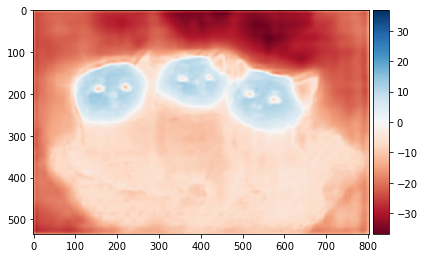

In [164]:
io.imshow(x_cpu[0,1,:,:].numpy())

In [172]:
device = torch.device("cuda")

In [26]:
model = torch.load("logs/20201130-165256/checkpoints/best_full.pth")

In [36]:
model = DeepLab(num_classes=18, pretrained=False) 
model.load_state_dict(torch.load("logs/20201130-165256/checkpoints/best.pth")['model_state_dict'])

<All keys matched successfully>

In [ ]:
model.to(device)
model.eval()

In [58]:
x = model(im.to(device))

In [180]:
x_cpu = x.detach().cpu().numpy()

In [181]:
prediction = nn.functional.softmax(torch.from_numpy(x_cpu[0]), dim=0).argmax(0).cpu().numpy()
prediction.shape

(535, 803)

/opt/conda/lib/python3.7/site-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning:

Low image data range; displaying image with stretched contrast.



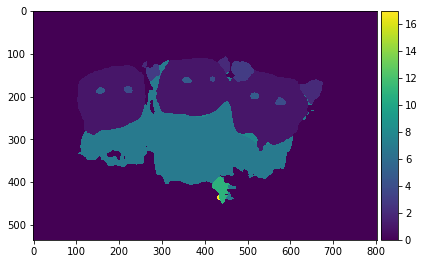

In [182]:
io.imshow(prediction)

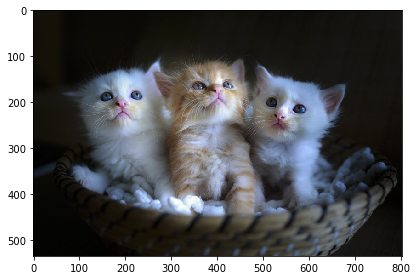

In [168]:
io.imshow(im1_);